# Global imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.svm import SVC
from qksvm.QKSVC import QKSVC

# Customized score functions
from qksvm.scores import get_scores, print_scores, print_cv_scores

# Custom visualization tools
from qksvm.visualization_tools import plot_dataset, plot_predictions, plot_decisions

import time

seed = 12345

# Blobs dataset

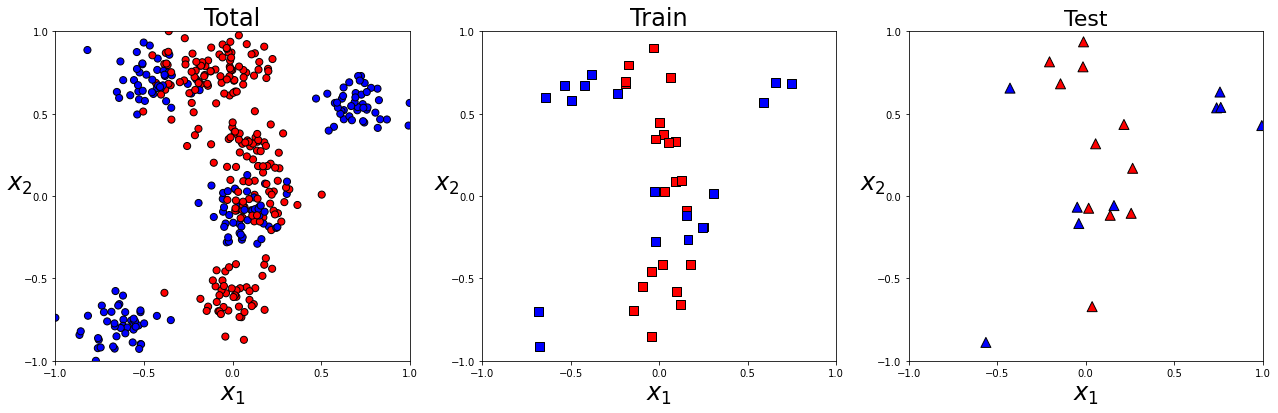

In [2]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

n_samples = 400
X, y = make_blobs(n_samples=n_samples, n_features=2, centers=9, random_state=120, shuffle=True, cluster_std=1.2)
y[y%2 == 0] = -1
y[y > 0] = 1

xmin = -1; xmax = 1
X = MinMaxScaler(feature_range=(xmin, xmax)).fit_transform(X)
axes = [xmin, xmax, xmin, xmax]

train_size = 40
test_size = 20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size,
    stratify=y, random_state=101
)

# Visualize the dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=24)
plot_dataset(X, y, ax1, axes)

ax2.set_title("Train", fontsize=24)
plot_dataset(X_train, y_train, ax2, axes, marker='s', size=80)

ax3.set_title("Test", fontsize=22)
plot_dataset(X_test, y_test, ax3, axes, marker='^', size=100)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

# QKT SVM

## Setting up the quantum feature map 

In [3]:
#------------------------
# Choose quantum backend
#------------------------
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = seed
backend = QuantumInstance(
    AerSimulator(
        method='statevector',
        max_parallel_threads=0,
    ),
    seed_simulator=seed, seed_transpiler=seed,
)

In [4]:
from qksvm.QuantumFeatureMap import QuantumFeatureMap

## Specify Feature Map
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=2,
    num_layers=5,
    gates=['RX', 'rzz', 'ry'], entanglement='linear',
    repeat=True,
    scale=True,
)
# closing encoding layer
for i in range(fm.num_qubits):
    fm.rx(fm.encod_params[i%fm.num_parameters], i)
print(fm.draw(plot_barriers=False, fold=120))

     ┌───────────────┐             ┌──────────┐ ┌───────────────┐             ┌──────────┐ ┌───────────────┐ »
q_0: ┤ Rx(x[0]*θ[0]) ├──■──────────┤ Ry(θ[2]) ├─┤ Rx(x[0]*θ[0]) ├──■──────────┤ Ry(θ[5]) ├─┤ Rx(x[0]*θ[0]) ├─»
     ├───────────────┤  │ZZ(θ[1])  ├──────────┤ ├───────────────┤  │ZZ(θ[4])  ├──────────┤ ├───────────────┤ »
q_1: ┤ Rx(x[1]*θ[0]) ├──■──────────┤ Ry(θ[3]) ├─┤ Rx(x[1]*θ[0]) ├──■──────────┤ Ry(θ[6]) ├─┤ Rx(x[1]*θ[0]) ├─»
     └───────────────┘             └──────────┘ └───────────────┘             └──────────┘ └───────────────┘ »
«                 ┌──────────┐ ┌───────────────┐              ┌───────────┐ ┌───────────────┐              »
«q_0: ─■──────────┤ Ry(θ[8]) ├─┤ Rx(x[0]*θ[0]) ├──■───────────┤ Ry(θ[11]) ├─┤ Rx(x[0]*θ[0]) ├──■───────────»
«      │ZZ(θ[7])  ├──────────┤ ├───────────────┤  │ZZ(θ[10])  ├───────────┤ ├───────────────┤  │ZZ(θ[13])  »
«q_1: ─■──────────┤ Ry(θ[9]) ├─┤ Rx(x[1]*θ[0]) ├──■───────────┤ Ry(θ[12]) ├─┤ Rx(x[1]*θ[0]) ├──■───────────»
«        

## Examine dependence of the kernel loss function on the data scaling prefactor

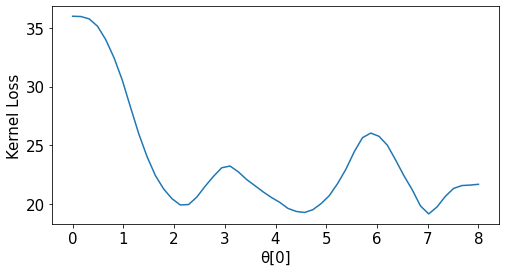

In [5]:
from qksvm.LossFunctions import SVCLoss
from qiskit_machine_learning.kernels import QuantumKernel

loss = SVCLoss(C=1)

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

kernel = QuantumKernel(fm, user_parameters=fm.train_params, quantum_instance=backend)
loss.plot(kernel, X_train, y_train, init_params, grid=[0, 8, 50], show=True)

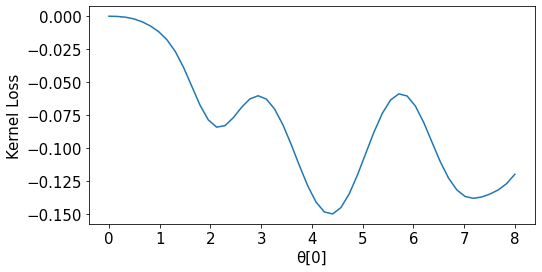

In [6]:
from qksvm.LossFunctions import KTALoss
from qiskit_machine_learning.kernels import QuantumKernel

loss = KTALoss()

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))

kernel = QuantumKernel(fm, user_parameters=fm.train_params, quantum_instance=backend)
loss.plot(kernel, X_train, y_train, init_params, grid=[0, 8, 50], show=True)

## Quantum Kernel Training

SVCLoss optimal value:  -0.4557459434530553
Optimal parameters: [ 4.58566992  5.83686419 -3.48068309  5.11066145  7.92279227  8.33616915
  6.49838372  7.7502276   3.60714715  6.20855542  6.40023616  1.43745635
  2.57222368  1.18489787 -1.75376855 12.08572202]


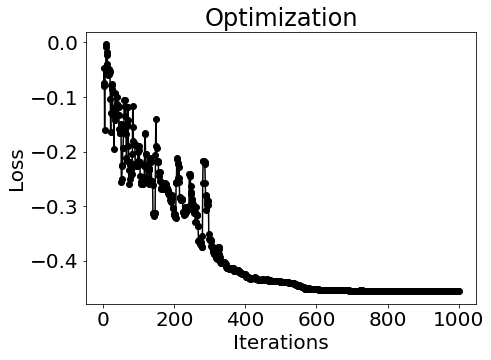

Number of function evaluations: 3000

Train scores:
   Balanced accuracy:  0.92
                  F1:  0.92
             ROC_AUC:  0.92
                 MCC:  0.85

Test scores:
   Balanced accuracy:  0.91
                  F1:  0.90
             ROC_AUC:  0.91
                 MCC:  0.82

Timing info: 00h04m34s


In [7]:
from qksvm.QuantumKernelTraining import QKTKernel
from qksvm.QuantumKernelTraining import TerminationChecker
from qiskit.algorithms.optimizers import SPSA
from sklearn.svm import SVC

t0 = time.perf_counter()

C = 1.0
class_weight = None

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 1.0

optimizer = SPSA(
    maxiter=1000,
    learning_rate=None,
    perturbation=None,
    # termination_checker=TerminationChecker(0.001, N=10),
    perturbation_dims=None,
)

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    C=C, class_weight=class_weight,
    optimizer=optimizer, loss=loss,
    backend=backend,
    seed=seed,
    plot=True,
)
print('Number of function evaluations:', qkt.optimizer_evals)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

t1 = time.perf_counter()
print('\nTiming info:', time.strftime("%Hh%Mm%Ss", time.gmtime(t1-t0)))

## Predictions/Decision boundaries plot

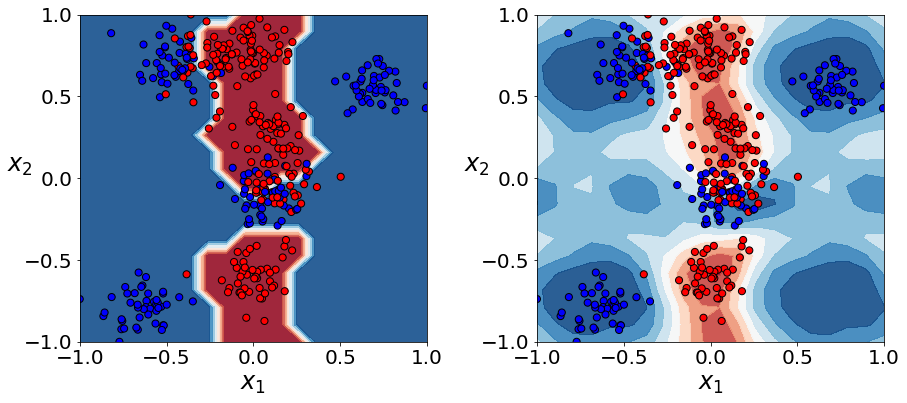

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()

# ADAM

SVCLoss optimal value:  -0.2187547057696367
Optimal parameters: [ 1.61436237  1.25185457  0.5054249   1.69155919  2.7765768   4.12332697
  6.91581791  4.23561017  4.48212533  3.85479413  4.58599098  5.43027045
 -0.64142754  0.83975612  0.83559311  3.18413182]


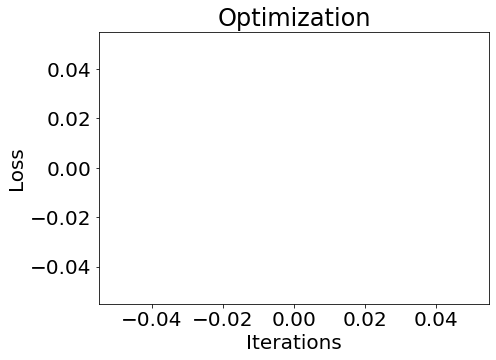

Number of function evaluations: 100

Train scores:
   Balanced accuracy:  0.84
                  F1:  0.85
             ROC_AUC:  0.84
                 MCC:  0.71

Test scores:
   Balanced accuracy:  0.70
                  F1:  0.70
             ROC_AUC:  0.70
                 MCC:  0.39
Timing info: 00h02m48s


In [9]:
from qksvm.QuantumKernelTraining import QKTKernel
from qksvm.QuantumKernelTraining import TerminationChecker
from qiskit.algorithms.optimizers import SPSA, ADAM
from sklearn.svm import SVC
from qiskit.utils import algorithm_globals

np.random.seed(seed)
algorithm_globals.random_seed = seed

t0 = time.perf_counter()

C = 1.0
class_weight = None

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 1.0

optimizer = ADAM(maxiter=100, lr=0.01, tol=1e-3)

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    C=C, class_weight=class_weight,
    optimizer=optimizer, loss=loss,
    backend=backend,
    seed=seed,
    plot=True,
)
print('Number of function evaluations:', qkt.optimizer_evals)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

t1 = time.perf_counter()
print( 'Timing info:', time.strftime("%Hh%Mm%Ss", time.gmtime(t1-t0)) )

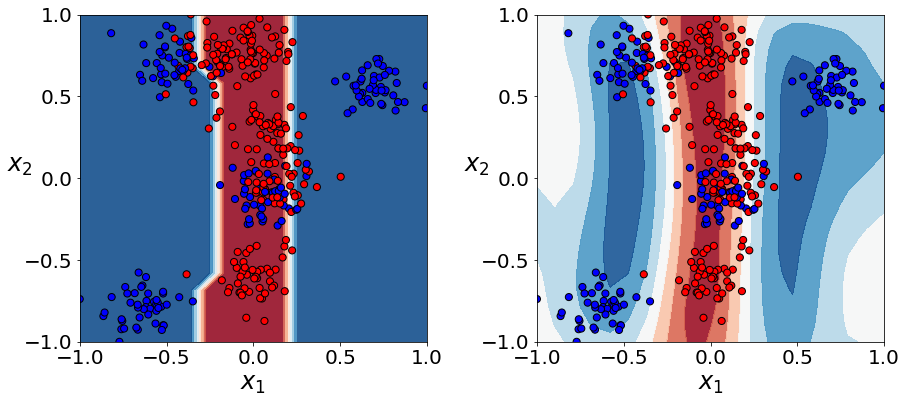

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()

# Batch optimization

In [11]:
from qksvm.QuantumKernelTraining import QKTKernel
from qiskit_machine_learning.kernels import QuantumKernel
from qksvm.QuantumKernelTraining import TerminationChecker
from qiskit.algorithms.optimizers import SPSA
from sklearn.svm import SVC
from functools import partial
from sklearn.model_selection import StratifiedShuffleSplit

t0 = time.perf_counter()

#----------------------
# Specify Feature Map
#----------------------
fm = QuantumFeatureMap(
    num_features=len(X_train[0]), 
    num_qubits=2,
    num_layers=5,
    gates=['RX', 'rzz', 'ry'], entanglement='linear',
    repeat=True,
    scale=True,
)
# closing encoding layer
for i in range(fm.num_qubits):
    fm.rx(fm.encod_params[i%fm.num_parameters], i)
print(fm.draw(plot_barriers=False, fold=120))

quantum_kernel = QuantumKernel(
    fm, user_parameters=fm.train_params, quantum_instance=backend 
)
    
C = 1.0
class_weight = None

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 4.0

from qiskit.algorithms.optimizers import ADAM, CG
optimizer = ADAM(maxiter=1, lr=0.01)
# optimizer = CG(maxiter=1)

loss = KTALoss()

maxiter = 1001
params = init_params
batch_size = 4

cv = StratifiedShuffleSplit(n_splits=1, train_size=batch_size, random_state=None)

for i in range(maxiter):
    
    # batch = np.random.choice(list(range(len(X_train))), batch_size)
    for idxs, _ in cv.split(X_train, y_train):
        batch = idxs
    # print(batch, y_train[batch])
    
    loss_function = partial(
        loss.evaluate, quantum_kernel=quantum_kernel, data=X_train[batch], labels=y_train[batch]
    )
    
    opt_results = optimizer.minimize(
        fun=loss_function,
        x0=params,
    )
    
    params = opt_results.x
    if i%20 == 0:
        _loss = loss.evaluate(params, quantum_kernel, X_train, y_train)
        print(i, params[0], _loss)

# Model training
quantum_kernel.assign_user_parameters(params)
qsvc = SVC(kernel=quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

t1 = time.perf_counter()
print( '\nTiming info:', time.strftime("%Hh%Mm%Ss", time.gmtime(t1-t0)) )

     ┌───────────────┐             ┌──────────┐ ┌───────────────┐             ┌──────────┐ ┌───────────────┐ »
q_0: ┤ Rx(x[0]*θ[0]) ├──■──────────┤ Ry(θ[2]) ├─┤ Rx(x[0]*θ[0]) ├──■──────────┤ Ry(θ[5]) ├─┤ Rx(x[0]*θ[0]) ├─»
     ├───────────────┤  │ZZ(θ[1])  ├──────────┤ ├───────────────┤  │ZZ(θ[4])  ├──────────┤ ├───────────────┤ »
q_1: ┤ Rx(x[1]*θ[0]) ├──■──────────┤ Ry(θ[3]) ├─┤ Rx(x[1]*θ[0]) ├──■──────────┤ Ry(θ[6]) ├─┤ Rx(x[1]*θ[0]) ├─»
     └───────────────┘             └──────────┘ └───────────────┘             └──────────┘ └───────────────┘ »
«                 ┌──────────┐ ┌───────────────┐              ┌───────────┐ ┌───────────────┐              »
«q_0: ─■──────────┤ Ry(θ[8]) ├─┤ Rx(x[0]*θ[0]) ├──■───────────┤ Ry(θ[11]) ├─┤ Rx(x[0]*θ[0]) ├──■───────────»
«      │ZZ(θ[7])  ├──────────┤ ├───────────────┤  │ZZ(θ[10])  ├───────────┤ ├───────────────┤  │ZZ(θ[13])  »
«q_1: ─■──────────┤ Ry(θ[9]) ├─┤ Rx(x[1]*θ[0]) ├──■───────────┤ Ry(θ[12]) ├─┤ Rx(x[1]*θ[0]) ├──■───────────»
«        

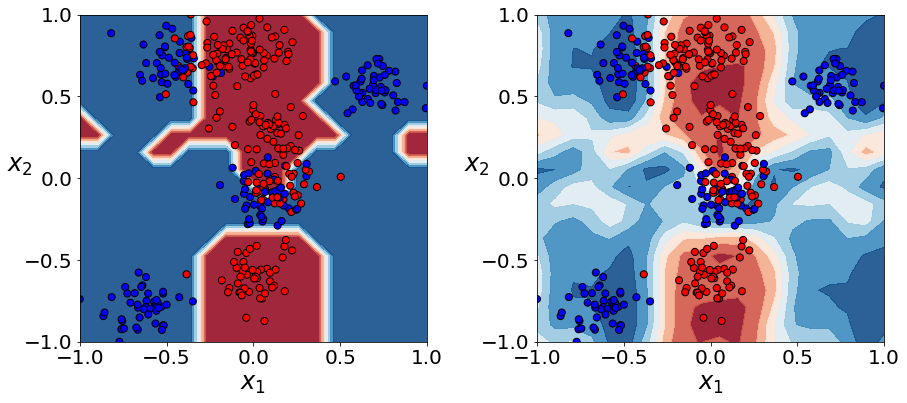

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()

# Tests

In [13]:
from qksvm.QuantumFeatureMap import QuantumFeatureMap

## Specify Feature Map
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=5,
    num_layers=5,
    gates=['RX', 'rzz', 'ry'], entanglement='linear',
    repeat=True,
    scale=True,
)

# closing encoding layer
for i in range(fm.num_qubits):
    fm.rx(fm.encod_params[i%fm.num_features], i)
print(fm.draw(plot_barriers=False, fold=120))

     ┌───────────────┐                                              ┌──────────┐ ┌───────────────┐             »
q_0: ┤ Rx(x[0]*θ[0]) ├──■───────────────────────────────────────────┤ Ry(θ[5]) ├─┤ Rx(x[1]*θ[0]) ├──■──────────»
     ├───────────────┤  │ZZ(θ[1])                                   ├──────────┤ ├───────────────┤  │ZZ(θ[10]) »
q_1: ┤ Rx(x[1]*θ[0]) ├──■──────────■────────────────────────────────┤ Ry(θ[6]) ├─┤ Rx(x[0]*θ[0]) ├──■──────────»
     ├───────────────┤             │ZZ(θ[2])                        ├──────────┤ ├───────────────┤             »
q_2: ┤ Rx(x[0]*θ[0]) ├─────────────■──────────■─────────────────────┤ Ry(θ[7]) ├─┤ Rx(x[1]*θ[0]) ├─────────────»
     ├───────────────┤                        │ZZ(θ[3])             ├──────────┤ ├───────────────┤             »
q_3: ┤ Rx(x[1]*θ[0]) ├────────────────────────■──────────■──────────┤ Ry(θ[8]) ├─┤ Rx(x[0]*θ[0]) ├─────────────»
     ├───────────────┤                                   │ZZ(θ[4])  ├──────────┤ ├──────────────

SVCLoss optimal value:  -0.33143020627135783
Optimal parameters: [ 2.57661573  2.7288651   1.01079588  0.06414885  3.26927455  3.23867017
  6.63088134  4.37283404  6.1914361   4.4500462   4.04113059  5.81569718
 -0.83074508  0.70381395  2.9382767   5.00035803  5.92092478  5.1587289
  6.92859493  5.84564004  3.87786952  4.40530547  2.61929987  2.30842287
  3.32027856  5.01135663  7.98660476  5.02943358  5.40397412  0.23046503
 -0.13736313  3.3016241   5.51356232  0.16215187  3.82615025  1.41282251
  2.90876829  0.12283324  5.66440726  4.90901867  4.60357652  2.84073147
  4.87692593  0.38342694  0.59543289  1.47742154]


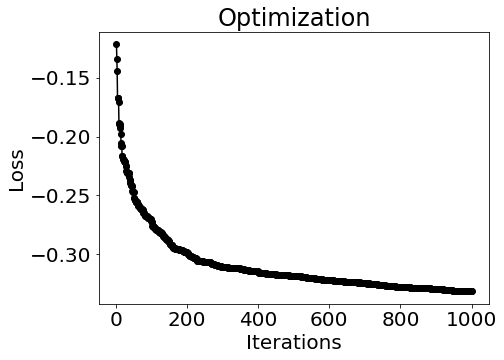

Number of function evaluations: 3000

Train scores:
   Balanced accuracy:  0.92
                  F1:  0.92
             ROC_AUC:  0.92
                 MCC:  0.85

Test scores:
   Balanced accuracy:  0.82
                  F1:  0.80
             ROC_AUC:  0.82
                 MCC:  0.66
Timing info: 00h07m55s


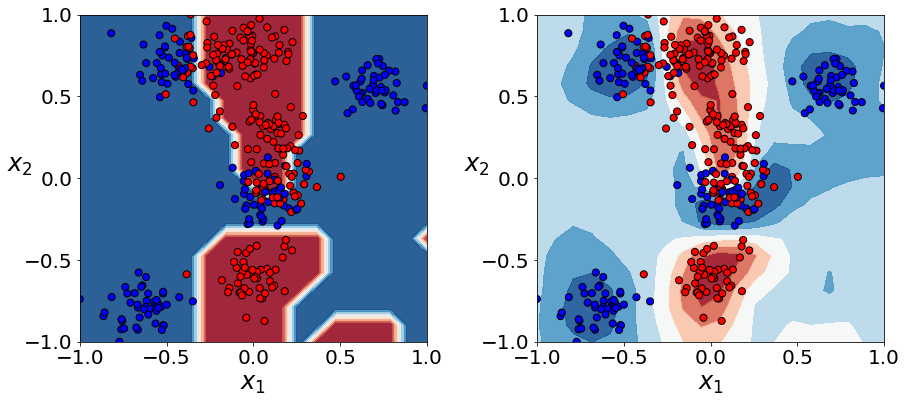

In [14]:
from qksvm.QuantumKernelTraining import QKTKernel
from qksvm.QuantumKernelTraining import TerminationChecker
from qiskit.algorithms.optimizers import SPSA
from sklearn.svm import SVC
from qiskit.utils import algorithm_globals
from qksvm.LossFunctions import KTALoss

t0 = time.perf_counter()

C = 1.0
class_weight = None

np.random.seed(seed)
init_params = np.random.uniform(0, 2*np.pi, len(fm.train_params))
init_params[0] = 1.0

algorithm_globals.random_seed = seed
optimizer = SPSA(
    maxiter=1000,
    learning_rate=None,
    perturbation=None,
    # termination_checker=TerminationChecker(0.001, N=10),
    perturbation_dims=None,
)

loss = KTALoss()

qkt = QKTKernel(
    fm,
    X_train, y_train,
    init_params,
    C=C, class_weight=class_weight,
    optimizer=optimizer, loss=loss,
    seed=seed,
    plot=True,
)
print('Number of function evaluations:', qkt.optimizer_evals)

# Model training
qsvc = SVC(kernel=qkt.quantum_kernel.evaluate, C=C, random_state=seed, class_weight=class_weight)
qsvc.fit(X_train, y_train)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

t1 = time.perf_counter()
print( 'Timing info:', time.strftime("%Hh%Mm%Ss", time.gmtime(t1-t0)) )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))

plot_predictions(qsvc, ax1, axes, N=20)
plot_dataset(X, y, ax1, axes)

plot_decisions(qsvc, ax2, axes, N=20)
plot_dataset(X, y, ax2, axes)

plt.tight_layout()
plt.show()